imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

loading the dataset

In [23]:
data = pd.read_csv('bank-full.csv', delimiter=';')
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


missing values

In [24]:
data.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


im converting the categorical features to numerical using one-hot encoding

In [25]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Handle unknown categories
encoded_data = pd.DataFrame(encoder.fit_transform(data[categorical_features]))
encoded_data.columns = encoder.get_feature_names_out(categorical_features)
data = data.drop(categorical_features, axis=1)
data = pd.concat([data, encoded_data], axis=1)

In [26]:
X = data.drop('y', axis=1)
y = data['y']

scaling

In [27]:
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


building the classification model

In [29]:
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),  # Added dropout for regularization
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Added another hidden layer
    layers.Dropout(0.3),  # Added dropout for regularization
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


compiling

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


training with early stopping

In [31]:
X_train = X_train.astype(float)
# Convert 'yes' and 'no' in y_train to 1 and 0 respectively
y_train = y_train.map({'yes': 1, 'no': 0}).astype(float)

# Proceed with model fitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Increased patience
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stop], verbose=0)

In [32]:
X_train_cols = X_train.columns
X_test_cols = X_test.columns
missing_cols_in_test = set(X_train_cols) - set(X_test_cols)
missing_cols_in_train = set(X_test_cols) - set(X_train_cols)

for col in missing_cols_in_test:
    X_test[col] = 0  # Add missing columns to X_test and fill with 0
for col in missing_cols_in_train:
    X_train[col] = 0  # Add missing columns to X_train and fill with 0

# Reorder columns to match
X_test = X_test[X_train_cols]

y_test = y_test.map({'yes': 1, 'no': 0}).astype(float)

# ***Check if y_test is empty before proceeding***
if y_test.empty:
    print("y_test is empty. Check data processing steps.")
else:
    # Remove rows with NaN values in y_test
    X_test = X_test[~y_test.isna()]
    y_test = y_test.dropna()

    # Now, X_test should contain only numeric columns and have the same features as X_train
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Generate predictions using the trained model
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.90
Precision: 0.66
Recall: 0.40
F1-Score: 0.50


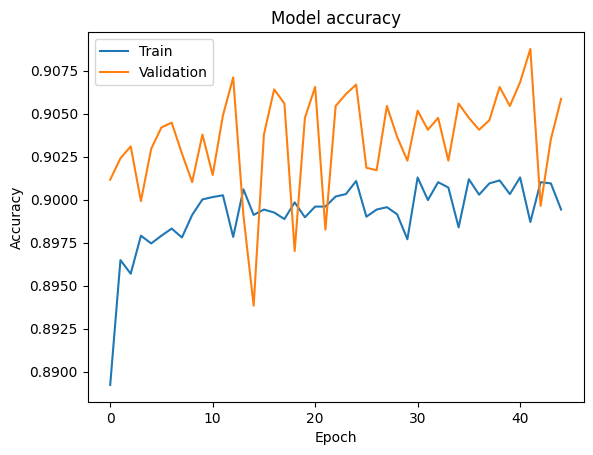

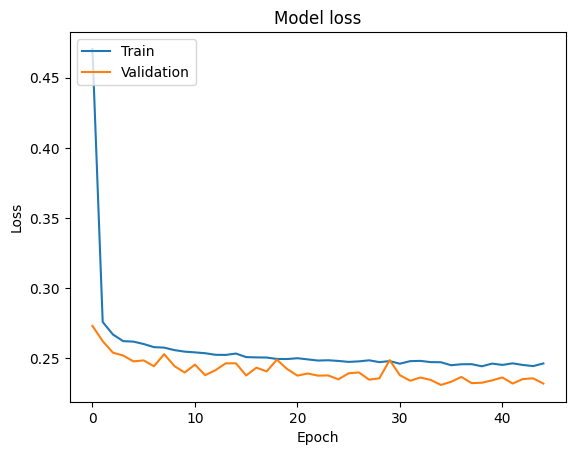

In [35]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()